In [26]:
import numpy as np
import matplotlib.pyplot as plt

# PCA

PCA stands for "principal components analysis".

The "principal components" in PCA are the axes of covariation. Intuition: if you look at a pairplot, in what direction (if any) do you see the variables pointing?

The idea behind PCA is:
* find the components (the intrinsic axes of variation)
* order them from largest to smallest
* drop the smallest ones

This gives a data set with fewer variables, but that still has most of the information of the full dataset. Note that this type of projection does *not drop data variables*, instead it drops variation between data variables.



We can do this using matrix math!
* Rotate so the principal coordinates become coordinate axes (translation then rotation), then 
* drop the lesser ones, then 
* reverse the rotation and translation: $$A_{reconstruct} = (P@A_c^T)^T + \mu = A_c @ P^T + \mu$$
    
The rotation matrix is the *eigenvectors* of the covariance matrix. The eigenvectors tell us the direction of the principal components. The eigenvalues tell us the amount of variation in each principal coordinate direction.


Reminder: the eigenvectors are *orthonormal*. What does that mean?

So the steps to calculate PCA are:
* (If appropriate) normalize the variables to be in the range 0-1
* Center the data
* Compute the covariance matrix
* Compute the eigenvectors and eigenvalues; the eigenvectors tell us the direction of variance, and the eigenvalues tell us the amount of variance
* Get an ordering over the eigenvalues
* Sort the eigenvalues and eigenvectors accordingly
* Compute the proportional variance (how much bigger?) accounted for by each principal component
* Compute the cumulative sum of the proportional variance (tells us how many eigenvectors we need to explain a desired amount of variance)
* Examine the principal components. Select v' of them.
* Project the data into PCA space
* Reconstruct the data

In [112]:
# Let's do it on a small dataset so we can see what's going on

data = np.array([[1, 4],[2, 3], [3, 2], [4, 1.0]])
print(data)
columns = ['x,', 'y']

[[1. 4.]
 [2. 3.]
 [3. 2.]
 [4. 1.]]


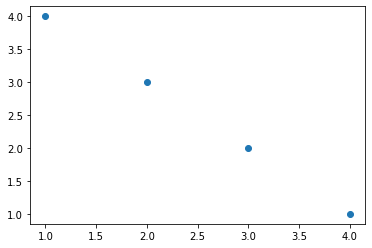

In [113]:
# Let's plot the data

plt.scatter(x = data[:, 0], y=data[:, 1])
plt.show()

# In which directions do the points vary?

(4, 2)


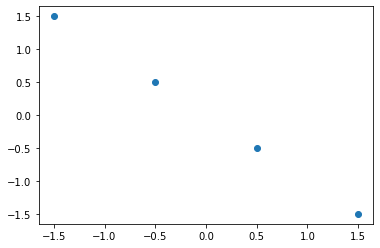

In [114]:
# Center the data

centered_data = data - np.mean(data, axis=0)
print(centered_data.shape)
plt.scatter(x = centered_data[:, 0], y=centered_data[:, 1])
plt.show()

In [115]:
# Compute the covariance matrix

covariance_matrix = (centered_data.T @ centered_data) / (data.shape[0] - 1)
print(covariance_matrix.shape)

(2, 2)


In [116]:
# Compute the eigenvalues and eigenvectors

(evals, evectors) = np.linalg.eig(covariance_matrix)
print(evals.shape)
print(evectors.shape)

(2,)
(2, 2)


In [117]:
# Get an ordering over the eigenvalues

evals_order = np.argsort(evals)[::-1]
print(evals_order)

[0 1]


In [118]:
# Sort the eigenvalues and eigenvectors accordingly

evals_sorted = evals[evals_order]
for e in evals_sorted:
    print(e)

# We looked up numpy linalg eig in class; the eigenvectors run along the *columns*, not the rows
evectors_sorted = evectors[:, evals_order]
print(evectors_sorted.shape)

3.333333333333333
-3.7007434154171886e-16
(2, 2)


In [119]:
# Compute the proportional variance

evals_sum = np.sum(evals_sorted)
ps = [eval / evals_sum for eval in evals_sorted]
print(ps)

[1.0000000000000002, -1.1102230246251568e-16]


In [120]:
# Compute the cumulative sum of the proportional variance

c = 0
for i in range(len(ps)):
    c = c + ps[i]
    print(i, ps[i], c)

0 1.0000000000000002 1.0000000000000002
1 -1.1102230246251568e-16 1.0


In [121]:
# Examine the principal components

print(evectors_sorted)

[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


In [122]:
# Construct v'

v = np.array([evectors_sorted[:, 0]]).T
print(v)

[[ 0.70710678]
 [-0.70710678]]


In [123]:
# Project the data into PCA space

projected_data = centered_data@v
print(projected_data)

[[-2.12132034]
 [-0.70710678]
 [ 0.70710678]
 [ 2.12132034]]


[[1. 4.]
 [2. 3.]
 [3. 2.]
 [4. 1.]]


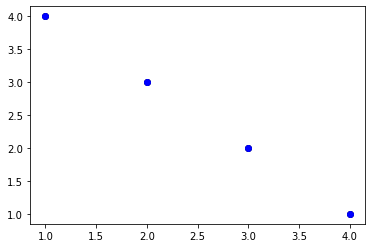

In [124]:
# Reconstruct the data with only the chosen principal components

reconstructed_data = projected_data@v.T + np.mean(data, axis=0)
print(reconstructed_data)
plt.scatter(x = reconstructed_data[:, 0], y=reconstructed_data[:, 1], color="black")
plt.scatter(x = data[:, 0], y=data[:, 1], color="blue")
plt.show()

If we do all this, then:
* what does the data look like in "PC space"?
* what does it look like projected back?
* how does a regression fit on the PC transformed data compare with one fit on the original data?
* What if all the points were on a line?

In [145]:
# Now let's do it on our big dataset!
import scipy as sp

columns=['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature','chorus_hit','sections','popularity']
data = np.array(np.genfromtxt('data/spotify_dataset.csv', delimiter=',', skip_header=1, usecols=(2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17), dtype=float, encoding='utf-8')) 

# center
centered_data = data - np.mean(data, axis=0)
print("centered data")
print(centered_data.shape)

# covariance
covariance_matrix = (centered_data.T @ centered_data) / (data.shape[0] - 1)
print("covariance matrix")
print(covariance_matrix.shape)

# svd
(evals, evectors) = np.linalg.eig(covariance_matrix)
print("eigenvalues, eigenvectors")
print(evals.shape)
print(evectors.shape)

# sort
evals_order = np.argsort(evals)[::-1]
evals_sorted = evals[evals_order]
evectors_sorted = evectors[:, evals_order]
print("sorted eigenvalues")
for e in evals_sorted:
    print(e)

# proportional variance
evals_sum = np.sum(evals_sorted)
ps = [e / evals_sum for e in evals_sorted]

# cumulative sum of proportional variance
print("cum sum prop var")
c = 0
for i in range(len(ps)):
    c = c + ps[i]
    print(i, ps[i], c)

# v
v = evectors_sorted[np.ix_(np.arange(evectors_sorted.shape[0]), [0, 1])]
print("v")
print(v.shape)

# project into PCA space
projected_data = centered_data@v
print("projected data")
print(projected_data.shape)

# reconstructed data
reconstructed_data = projected_data@v.T + np.mean(data, axis=0)
print("reconstructed data")
print(reconstructed_data.shape)

# From Day 12
# assume these are numpy arrays
def rsquared(y, yhat):
    if len(y) != len(yhat):
        print("Need y and yhat to be the same length!")
        return 0
    return ((yhat - y.mean())**2).sum() / ((y - y.mean())**2).sum()

# multiple linear regression  
def fit(data, independent, dependent):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]
    print(x.shape)
    
    # We add a column of 1s for the intercept
    A = np.hstack((np.array([np.ones(x.shape[0])]).T, x))

    # This is the dependent variable 
    y = data[:, dependent]

    # This is the regression coefficients that were fit, plus some other results
    c, res, _, _ = sp.linalg.lstsq(A, y)
    return c, res

def predict(data, independent, c):
    # These are our independent variable(s)
    x = data[np.ix_(np.arange(data.shape[0]), independent)]

    # We add a column of 1s for the intercept
    A = np.hstack((np.array([np.ones(x.shape[0])]).T, x))

    return np.dot(A, c)

c, res = fit(data, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 0)
print(c, res)
yhat = predict(data, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], c)
rs = rsquared(data[:, 0], yhat)
print(rs)

c1, res1 = fit(reconstructed_data, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 0)
print(c1, res1)
yhat = predict(reconstructed_data, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], c1)
rs1 = rsquared(reconstructed_data[:, 0], yhat)
print(rs1)

centered data
(41099, 16)
covariance matrix
(16, 16)
eigenvalues, eigenvectors
(16,)
(16, 16)
sorted eigenvalues
14153757017.333025
848.9629092078403
356.9309843409062
27.485438963116437
12.495710147178318
4.19658567869681
0.25843669691081395
0.2033293617670607
0.17282723519279652
0.08204913011190491
0.07482609110134858
0.05708022556689704
0.03149352247716357
0.017998889432496105
0.011889724923685565
0.006227958482163097
cum sum prop var
0 0.9999999116144445 0.9999999116144445
1 5.998144755008313e-08 0.999999971595892
2 2.521810656748288e-08 0.9999999968139986
3 1.9419180716569695e-09 0.9999999987559167
4 8.828545683973164e-10 0.9999999996387713
5 2.9649974226913854e-10 0.999999999935271
6 1.825922783274118e-11 0.9999999999535303
7 1.436575063049904e-11 0.999999999967896
8 1.2210695697666494e-11 0.9999999999801067
9 5.796985405321546e-12 0.9999999999859037
10 5.2866588281944614e-12 0.9999999999911904
11 4.0328670650434236e-12 0.9999999999952233
12 2.2250996435097326e-12 0.9999999999974

Resources:
* https://plotly.com/python/pca-visualization/
* https://wendynavarrete.com/principal-component-analysis-with-numpy/
* https://dev.to/akaame/implementing-simple-pca-using-numpy-3k0a